In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import copy
import numpy as np
import time

from ipynb.fs.full.FL_Lib import load_dataset, getActualImgs, averageModels

In [103]:
class Arguments():
    def __init__(self):
        self.images = 20 #60000 # number of images IMNIST - 60K
        self.clients = 2 # no. of clients
        self.rounds = 2 # no. of round : share model to client then return back weights
        self.epochs = 2 # no. of training localy
        self.local_batches = 10 # is the number of split of the the split_size, this is used in the client side
        self.lr = 0.01 # learning rate
        self.C = 1 #0.9 # from the Paper "C', where used to select number of clients; m= max(C* clients,1)
        # in the paper https://arxiv.org/pdf/1602.05629.pdf, C is set random, but for practicing we will make it fixed
        # we have total client, then slected set, then active set which selected - droped client
        self.drop_rate = 0 # 0.1 # drop rate of clients
        self.torch_seed = 0 # random seed to reproduce the same random result
        self.log_interval = 10 # after how many batches you want to print the acuracy and loss 
        self.iid = 'iid' # iid type
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images # n as the papers , it can be used only if the samples are balanced, otherwise use the unbalanced samples for each client
        self.use_cuda = False
        self.save_model = False

args = Arguments()

use_cuda = args.use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers':1, 'pin_memory':True} if use_cuda else {}


In [104]:
hook = sy.TorchHook(torch)
clients = []

for i in range(args.clients):
    clients.append({'hook':sy.VirtualWorker(hook, id="client{}".format(i+1))})

In [105]:
# Download MNIST manually using 'wget' then uncompress the file
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-11-08 00:02:49--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-11-08 00:02:49--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [      <=>           ]  33.20M  5.95MB/s    in 5.7s    

2022-11-08 00:02:55 (5.81 MB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [106]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid)

In [107]:
for inx, client in enumerate(clients):
    trainset_ind_list = list(train_group[inx])[:10] # here we can select how many training and accordingly the self images shall be changed
    client['trainset'] = getActualImgs(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getActualImgs(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images # in case of unbalanced samples between clients so that the args.samples will be useless

In [108]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
global_test_dataset = datasets.MNIST(root = "./", train = False, transform = transform, target_transform = None, download = True)
global_test_loader = DataLoader(global_test_dataset, args.local_batches, shuffle=True)
    

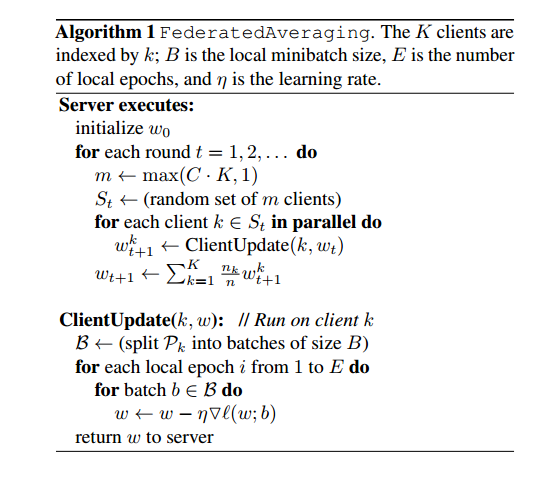

https://arxiv.org/pdf/1602.05629.pdf

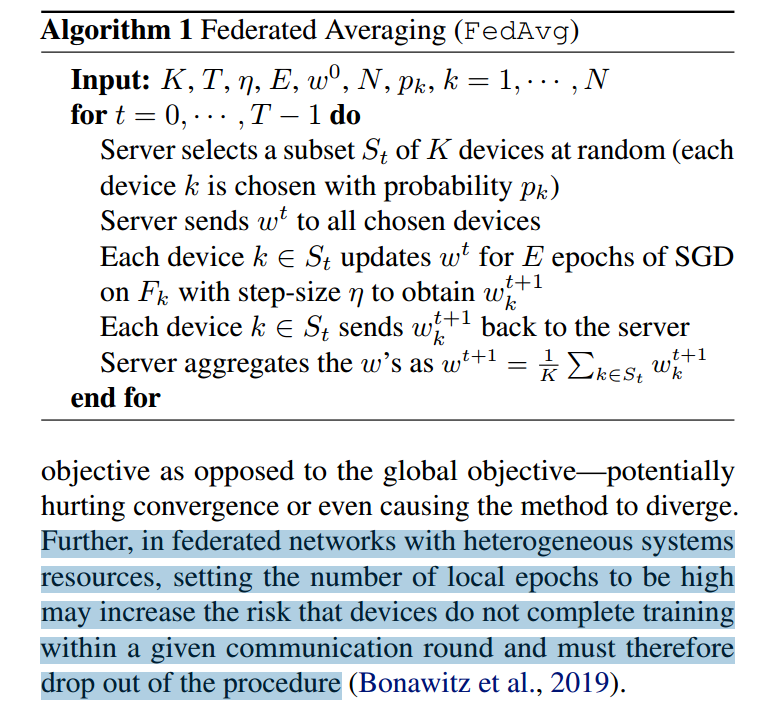

https://arxiv.org/pdf/1812.06127.pdf

In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [110]:
def clientUpdate(args, device, client):
    client['model'].train()
    
    # send model
    client['model'].send(client['hook'])
    
    for epoch in range(1, args.epochs+1):
        for batch_idx, (data, target) in enumerate(client['trainset']):
            # send data and target
            data = data.send(client['hook'])
            target = target.send(client['hook'])
            
            # training steps
            # set device cpu or gpu
            data, target = data.to(device), target.to(device)
            client['optim'].zero_grad()
            output = client['model'](data)
            loss = F.nll_loss(output, target)
            loss.backward()
            client['optim'].step()
            
            # tracing
            if batch_idx % args.log_interval == 0:
                loss = loss.get()
                print('model {} Train Epoch: {} [{}/{} ({:0f}%)]/tLoss: {:.6f}'.format(
                client['hook'].id,
                epoch, batch_idx*args.local_batches, len(client['trainset'])* args.local_batches,
                100.*batch_idx / len(client['trainset']), loss))
                
        # get the client updated model
    client['model'].get()

In [115]:
def test(args, model, device, test_loader, name):
    model.eval() # to set any training data to false
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
        
    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)))

In [116]:
torch.manual_seed(args.torch_seed) # seed for global model
global_model = Net() # we will not use the global model for training 
# we will use the global model fro average for clients weight
# there is no global optimizer because we are going to avergae clients weight and no need to train the global model

# loop in each client to initiate model and optimizer 
for client in clients:
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    
# Implement round for loop

for fed_round in range(args.rounds):
    
    #     uncomment if you want a randome fraction for C every round
    #     args.C = float(format(np.random.random(), '.1f'))

    # number of selected clients
    m = int(max(args.C * args.clients, 1))
    
    # Selected devices
    np.random.seed(fed_round)
    selected_clients_inds = np.random.choice(range(len(clients)),m, replace=False)
    selected_clients = [clients[i] for i in selected_clients_inds]
    
    # Active Devices
    np.random.seed(fed_round)
    active_clients_inds = np.random.choice(selected_clients_inds,int((1-args.drop_rate)*m), replace=False)
    active_clients = [clients[i] for i in active_clients_inds]
    
    # Training
    for client in active_clients:
        clientUpdate(args, device, client)
    
    # Averaging
    global_model = averageModels(global_model, clients) # here we will avergae in all the clients
    # if we want to average on only the active clients
    # global_model = averageModels(global_model, active_clients
    
    # Testing
    test(args, global_model, device, global_test_loader, 'Global')

    # Share the global model with the clients
    for client in clients:
        client['model'].load_state_dict(global_model.state_dict())
        
if (args.save_model):
    torch.save(global_model.state_dict(), "FedAvg.pt")


model client1 Train Epoch: 1 [0/10 (0.000000%)]/tLoss: 2.298784
model client1 Train Epoch: 2 [0/10 (0.000000%)]/tLoss: 2.267735
model client2 Train Epoch: 1 [0/10 (0.000000%)]/tLoss: 2.364049
model client2 Train Epoch: 2 [0/10 (0.000000%)]/tLoss: 2.305901

Test set: Average loss for Global model: 2.3041, Accuracy: 1030/10000 (10%)

model client1 Train Epoch: 1 [0/10 (0.000000%)]/tLoss: 2.276051
model client1 Train Epoch: 2 [0/10 (0.000000%)]/tLoss: 2.246052
model client2 Train Epoch: 1 [0/10 (0.000000%)]/tLoss: 2.314963
model client2 Train Epoch: 2 [0/10 (0.000000%)]/tLoss: 2.260366

Test set: Average loss for Global model: 2.2965, Accuracy: 1016/10000 (10%)

